<a href="https://colab.research.google.com/github/xkumachii/pneumonia/blob/heatmaps/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [32]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras import Model, Input, models, layers
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

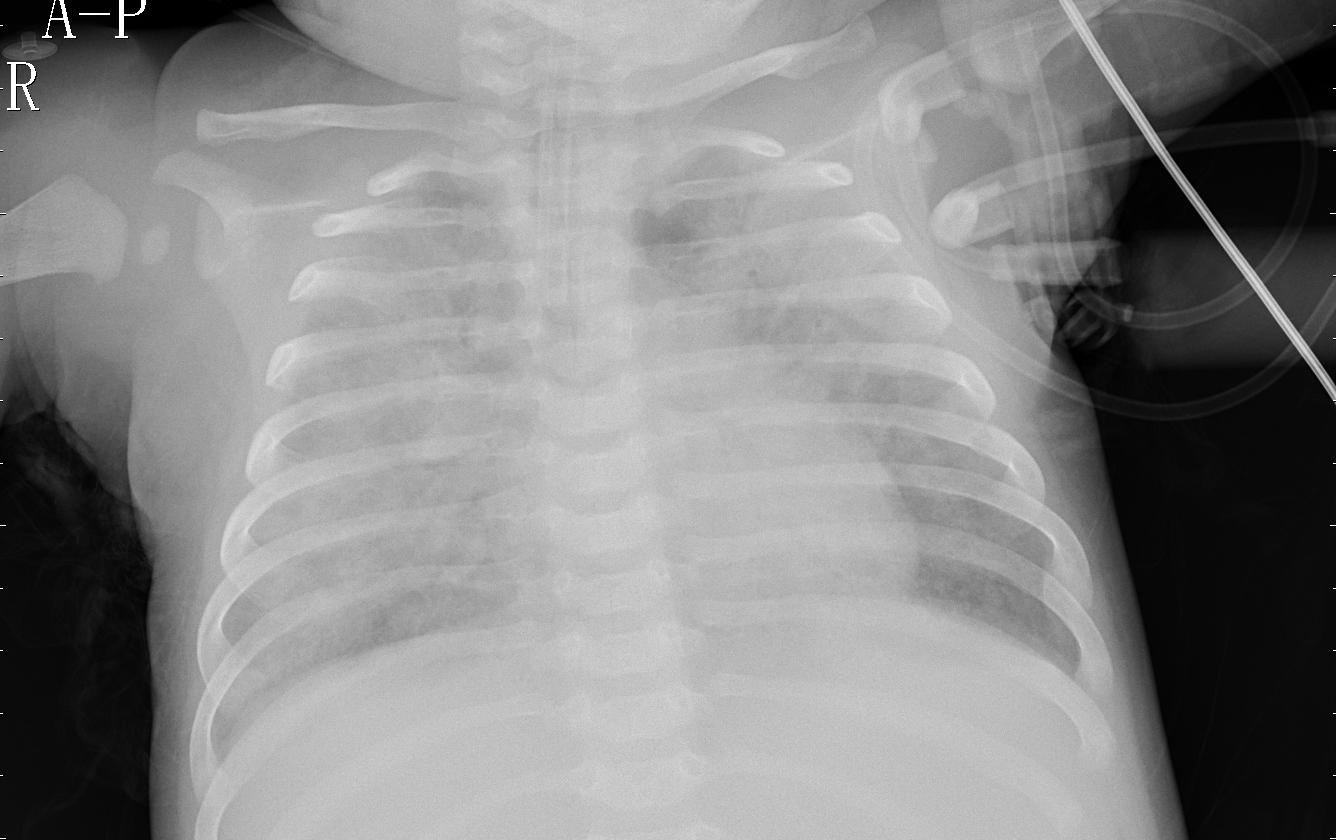

In [33]:

# The local path to the target image
img_path = "/content/drive/Shared drives/Pneumonia/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

#TODO: Display an image. 
# More downsizing may be necessary to reduce training cost.

display(Image(img_path))

In [34]:
# unused, taken from https://keras.io/examples/vision/xray_classification_with_tpus/. go delete this

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, (4,4))


def process_path(image, path):
    label = get_label(path)
    # # load the raw data from the file as a string
    img = decode_img(image)
    return img, label

In [35]:
def load_data(path):
  imgs = []
  labels = np.array([])

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      # To reduce training costs, the images are resized to 200x200.
      img = image.load_img(temp_path + "/" + f, target_size=(299,299))
      x = image.img_to_array(img)
      imgs.append(x)
      labels = np.append(labels, [int(dir == 'PNEUMONIA')])

      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1

  imgs = np.asarray(imgs)
  print(imgs.shape) # left there for debug
  return imgs, labels


In [36]:
# validation data was used as training data to debug things
# X_train, y_train = load_data("/content/drive/Shared drives/Pneumonia/train")
# X_test, y_test = load_data("/content/drive/Shared drives/Pneumonia/test")
X_val, y_val = load_data("/content/drive/Shared drives/Pneumonia/val")

Files loaded for /content/drive/Shared drives/Pneumonia/val: 0
Files loaded for /content/drive/Shared drives/Pneumonia/val: 0
(16, 299, 299, 3)


In [37]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))


In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 322624)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [39]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))
model.fit(X_val, y_val, epochs=15, batch_size=32) #this line is for debug purposes

Epoch 1/15
1/1 [==============================] - 0s 3ms/step - loss: 6.7322 - accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 20ms/step - loss: 6080.3062 - accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 0s 20ms/step - loss: 29.0803 - accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 0s 20ms/step - loss: 505.6950 - accuracy: 0.5000
Epoch 5/15
1/1 [==============================] - 0s 20ms/step - loss: 6.0507 - accuracy: 0.5625
Epoch 6/15
1/1 [==============================] - 0s 20ms/step - loss: 513.9083 - accuracy: 0.5000
Epoch 7/15
1/1 [==============================] - 0s 23ms/step - loss: 0.0113 - accuracy: 1.0000
Epoch 8/15
1/1 [==============================] - 0s 20ms/step - loss: 8.6157e-05 - accuracy: 1.0000
Epoch 9/15
1/1 [==============================] - 0s 20ms/step - loss: 8.3746e-05 - accuracy: 1.0000
Epoch 10/15
1/1 [==============================] - 0s 19ms/step - loss: 8.1714e-05 - accuracy: 1.0000
Epoch 11/1

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 322624)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [41]:
model= tf.keras.applications.Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=max,
    classes = 2,
    classifier_activation="softmax",
)

In [42]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [43]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))
model.fit(X_val, y_val, epochs=15, batch_size=32) #this line is for debug purposes

Epoch 1/15
1/1 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 308ms/step - loss: 2.2150 - accuracy: 0.5625
Epoch 3/15
1/1 [==============================] - 0s 312ms/step - loss: 0.8183 - accuracy: 0.5625
Epoch 4/15
1/1 [==============================] - 0s 305ms/step - loss: 1.8179 - accuracy: 0.4375
Epoch 5/15
1/1 [==============================] - 0s 339ms/step - loss: 1.4794 - accuracy: 0.4375
Epoch 6/15
1/1 [==============================] - 0s 316ms/step - loss: 1.9928 - accuracy: 0.5000
Epoch 7/15
1/1 [==============================] - 0s 305ms/step - loss: 0.9386 - accuracy: 0.3750
Epoch 8/15
1/1 [==============================] - 0s 321ms/step - loss: 1.1105 - accuracy: 0.3125
Epoch 9/15
1/1 [==============================] - 0s 307ms/step - loss: 0.7817 - accuracy: 0.5000
Epoch 10/15
1/1 [==============================] - 0s 312ms/step - loss: 0.8069 - accuracy: 0.5000
Epoch 11/15
1/1 [====

In [50]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

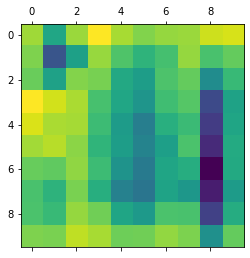

In [52]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
img_array = preprocess_input(get_img_array(img_path, size = (299, 299)))


last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)

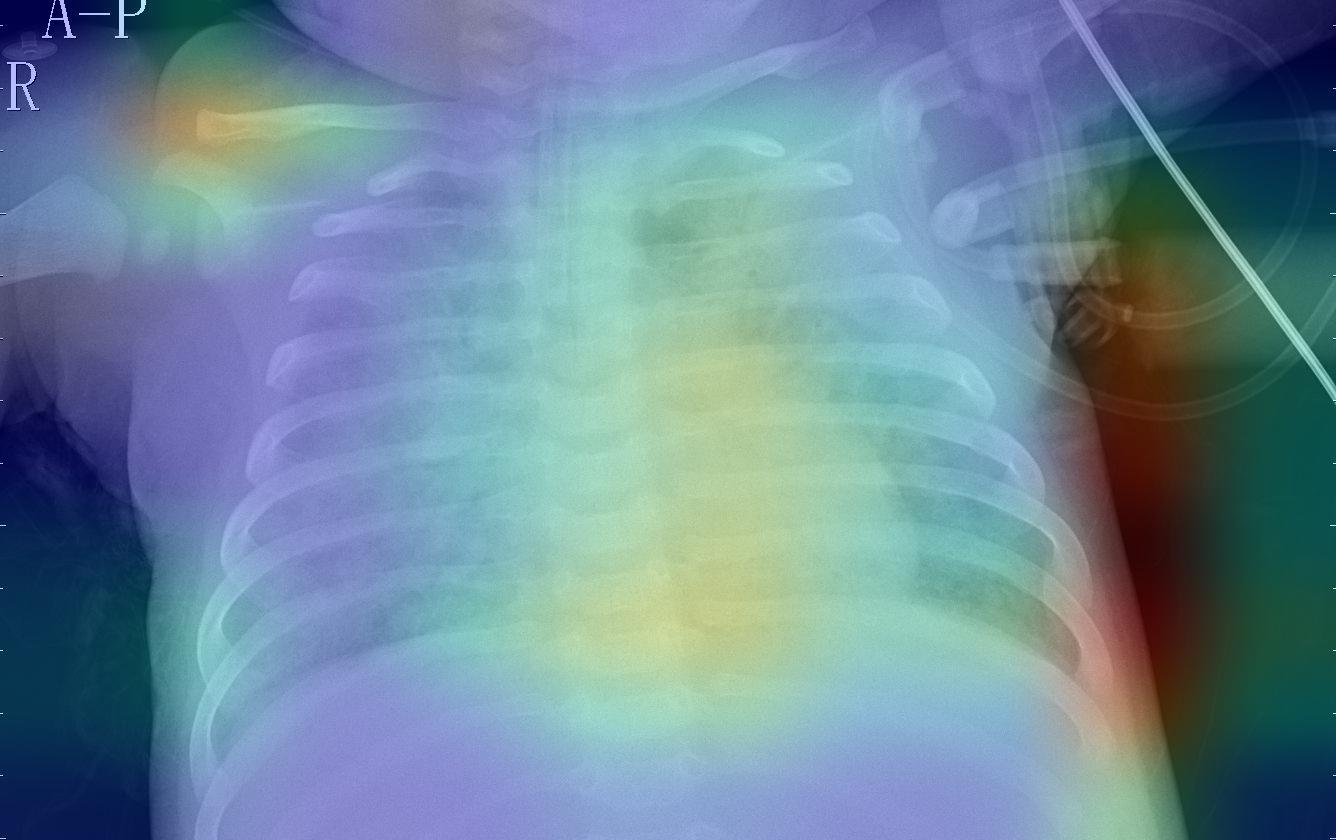

In [54]:
# We load the original image
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "pneumonia_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))